In [1]:
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import threading

In [19]:
ROUNDS = 20
PROBFAIL = 0.1
NCLIENTS = 50
MAX_CHAOTIC_ENTRIES = 20
TEST_SIZE = 1000

# Separação dos dados em treinamento e teste
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Pré-processamento dos dados. Imagens 28 x 28. Valores de pixels normalizados (0<=p<=1).
X_train = X_train.reshape((60000, 28 * 28))
X_train = X_train.astype('float32') / 255

X_test = X_test.reshape((10000, 28 * 28))
X_test = X_test.astype('float32') / 255

y_train = to_categorical(y_train)  # Convertendo rótulos para one-hot encoding
y_test = to_categorical(y_test)    # Convertendo rótulos para one-hot encoding

# Inicialização do modelo centralizado
model_centralized = Sequential()
model_centralized.add(Dense(units=32, activation='relu', input_dim=784))
model_centralized.add(Dense(units=10, activation='softmax'))

# Inicialização do modelo federado
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=784))
model.add(Dense(units=10, activation='softmax'))


In [3]:
# model_centralized.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# history = model_centralized.fit(X_train,y_train, epochs=5,batch_size=32, verbose=1,validation_data=(X_test, y_test))

# train_acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# fig, axs = plt.subplots(1,2, figsize=(12,4))
# line_labels = ['Train', 'Validation']

# axs[0].title.set_text(f'Centralized Training')
# axs[0].set_xlabel('Epochs')
# axs[0].set_ylabel('Accuracy')
# l1 = axs[0].plot(train_acc, color='blue')[0]
# l2 = axs[0].plot(val_acc, color='green')[0]

# axs[1].title.set_text(f'Centralized Training')
# axs[1].set_xlabel('Epochs')
# axs[1].set_ylabel('Loss')
# l1 = axs[1].plot(train_loss, color='blue')[0]
# l2 = axs[1].plot(val_loss, color='green')[0]

# # Create the legend
# fig.legend([l1, l2],     # The line objects
#            labels=line_labels,   # The labels for each line
#            loc="center right",   # Position of legend
#            borderaxespad=0.1,    # Small spacing around legend box
#            title="Legend Title"  # Title for the legend
#            )

In [20]:
class Server:
    def __init__(self,global_model) -> None:
        self.global_model = global_model

class Client:
    def __init__(self, model = None) -> None:
        self.model = model

    def update(self,Xi,yi):
        self.weight = len(Xi)
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.fit(Xi, yi, epochs=1, batch_size=32, verbose=0)

# Inicialização do servidor
s = Server(model)

# Inicialização dos clientes
clients = {}
for n in range(NCLIENTS):
    clients[f"c{n}"] = Client()

rounds = []
global_accuracies = []
global_losses = []
threads = []
for round in range(ROUNDS):
    active_clients_list = [v for k,v in clients.items() if PROBFAIL <= random.uniform(0, 1)]

    try:
        for i,client in enumerate(active_clients_list):
            client.model = s.global_model

            # Considerando os 60.000 dados de treino, selecionar até MAX_CHAOTIC_ENTRIES aleatoriamente para treinamento de cada cliente
            samples = random.sample(range(1, len(X_train)), random.randint(1, MAX_CHAOTIC_ENTRIES))
            Xi = X_train[samples]
            yi = y_train[samples]

            thread = threading.Thread(target=client.update(Xi,yi), args=(i+1,))
            threads.append(thread)
            thread.start()

        # Esperando todos os threads terminarem antes de prosseguir
        for thread in threads:
            thread.join()
        
        clients_weights = [client.weight for client in active_clients_list]
        clients_weights_norm = np.array(clients_weights) / np.sum(clients_weights)

        # Formato:[[c0w0,c0w1,c0w2,c0w3],[c1w0,c1w1,c1w2,c1w3],[c2w0,...],...]. Para cada camada são 2 tipos de pesos considerados: weights e biases.
        wbs = [[active_client.model.get_weights()[i] * wgs_norm for i in range(len(2*client.model.layers))] for active_client,wgs_norm in zip(active_clients_list,clients_weights_norm)]

        # [sum(c0w0,c1w0,...cnw0),sum(c0w1,c1w1,...cnw1),...,sum(c0wm,c1wm,...cnwm)]. Mantém a ordem: pesos,biases,pesos,biases,...
        weights = [np.sum(z,axis=0) for z in zip(*wbs)]

        s.global_model.set_weights(weights)

        # Acurácia e perda globais (modelo agregado).
        loss, acc = s.global_model.evaluate(X_test[:TEST_SIZE], y_test[:TEST_SIZE], verbose=0)
        print(f"Round {round}. GLOBAL ACC: {acc}")

        rounds.append(round)
        global_losses.append(loss)
        global_accuracies.append(acc)

    except Exception as e:
        # Se não houver clientes ativos na rodada, o desempenho de loss e acc deve ser igual ao último desempenho obtido
        print(e)
        print("All clients disconnected.Waiting connection...")
        rounds.append(round)

        if round == 0:
            global_losses.append(0)
            global_accuracies.append(0)
        else:
            previous_loss = global_losses[-1]
            previous_accuracy = global_accuracies[-1]

            global_losses.append(previous_loss)
            global_accuracies.append(previous_accuracy)
        continue

Round 0. GLOBAL ACC: 0.4309999942779541
Round 1. GLOBAL ACC: 0.6140000224113464
Round 2. GLOBAL ACC: 0.7450000047683716
Round 3. GLOBAL ACC: 0.7940000295639038
Round 4. GLOBAL ACC: 0.8100000023841858
Round 5. GLOBAL ACC: 0.8149999976158142
Round 6. GLOBAL ACC: 0.8460000157356262
Round 7. GLOBAL ACC: 0.8330000042915344
Round 8. GLOBAL ACC: 0.8410000205039978
Round 9. GLOBAL ACC: 0.8399999737739563
Round 10. GLOBAL ACC: 0.8489999771118164
Round 11. GLOBAL ACC: 0.8489999771118164
Round 12. GLOBAL ACC: 0.843999981880188
Round 13. GLOBAL ACC: 0.8500000238418579
Round 14. GLOBAL ACC: 0.8560000061988831
Round 15. GLOBAL ACC: 0.8519999980926514
Round 16. GLOBAL ACC: 0.8500000238418579
Round 17. GLOBAL ACC: 0.8479999899864197
Round 18. GLOBAL ACC: 0.8650000095367432
Round 19. GLOBAL ACC: 0.8640000224113464


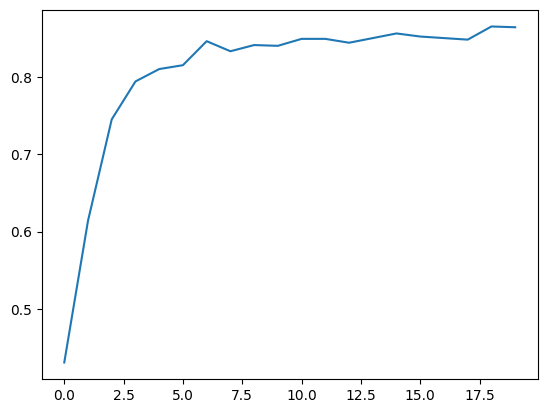

In [21]:
plt.plot(rounds,global_accuracies)